---
title: "Waiting time analysis"
---

[Archived notebook using Python and R](analysis/01_occurence_rate.ipynb)

## Notes

- Occurence rate is related to the waiting time distribution.
- Group the data by the radial distance for WT analysis is not good as the radial distance is not a monotonic function of time. 

It is hard to remove duplicate events when combining multiple datasets with different τ. So when using the combined dataset, the occurence rate would be overestimated.


> An analysiswas carried out to determine the probability distribution governing the time interval between successive discontinuities. The times at which the discontinuities occurred,obtainedfromthe identificationprogram, were used to computethe time difference, $τ = T_j - T_{j-1}$, the so-called interarrival interval. The number of cases were then tabulated corresponding to discreteranges of τ, and a histogramwas prepared.By properly normalizing the numberof casesin each range a probability distribution function giving the relative frequency of occurrencewas obtained. A similar study was previously carried out by Burlaga[1969].

## References

- [Weibull distribution - Distributions.jl](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Weibull)

$$
f(x; \alpha, \theta) = \frac{\alpha}{\theta} \left( \frac{x}{\theta} \right)^{\alpha-1} e^{-(x/\theta)^\alpha}, \quad x \ge 0
$$

In [2]:
using DrWatson
@quickactivate
include(srcdir("main.jl"))

using CairoMakie

In [3]:
# j_events_taus = load_taus(60:-10:20);
wind_df = load(datadir("updated_events_Wind_tr=20110825-20160630_method=fit_tau=0:01:00_ts=0:00:00.090909.arrow"));
# jno_df = load(datadir("updated_events_JNO_method=fit_tau=0:01:00_ts=0:00:01.arrow"));
jno_df = load(datadir("updated_events_JNO_tr=20110825-20160630_method=fit_tau=0:01:00_ts=0:00:01.arrow"));

┌ Warning: automatically converting Arrow.Timestamp with precision = MICROSECOND to `DateTime` which only supports millisecond precision; conversion may be lossy; to avoid converting, pass `Arrow.Table(source; convert=false)
└ @ Arrow /Users/zijin/.julia/packages/Arrow/rIDSw/src/eltypes.jl:273
┌ Warning: automatically converting Arrow.Timestamp with precision = NANOSECOND to `DateTime` which only supports millisecond precision; conversion may be lossy; to avoid converting, pass `Arrow.Table(source; convert=false)
└ @ Arrow /Users/zijin/.julia/packages/Arrow/rIDSw/src/eltypes.jl:273


In [4]:
subset_jno(df, r) = subset(df, :radial_distance => x -> round_c.(x) .== r)
subset_time(df, t) = subset(df, :time => x -> x .< t)

subset_time (generic function with 1 method)

In [79]:
bin(x, bin_size) = @. round(x / bin_size) * bin_size
bin(bin_size) = x -> bin(x, bin_size)

bin (generic function with 2 methods)

In [120]:
df = wind_df;
df_s1 = subset(df, :time => t -> year.(t) .== 2013);
df_s2 = subset(df_s1, :time => t -> month.(t) .< 2);

jno_df_s1 = subset(jno_df, :time => t -> year.(t) .== 2011);
jno_df_s2 = subset(jno_df, :time => t -> year.(t) .== 2016);

In [63]:
using Distributions

get_fit_params(x; dist=Weibull, func=mean) = func(fit(dist, x))
get_wt_fit_params(time; kwargs...) = get_fit_params(waiting_time(time); kwargs...)

get_wt_fit_params (generic function with 1 method)

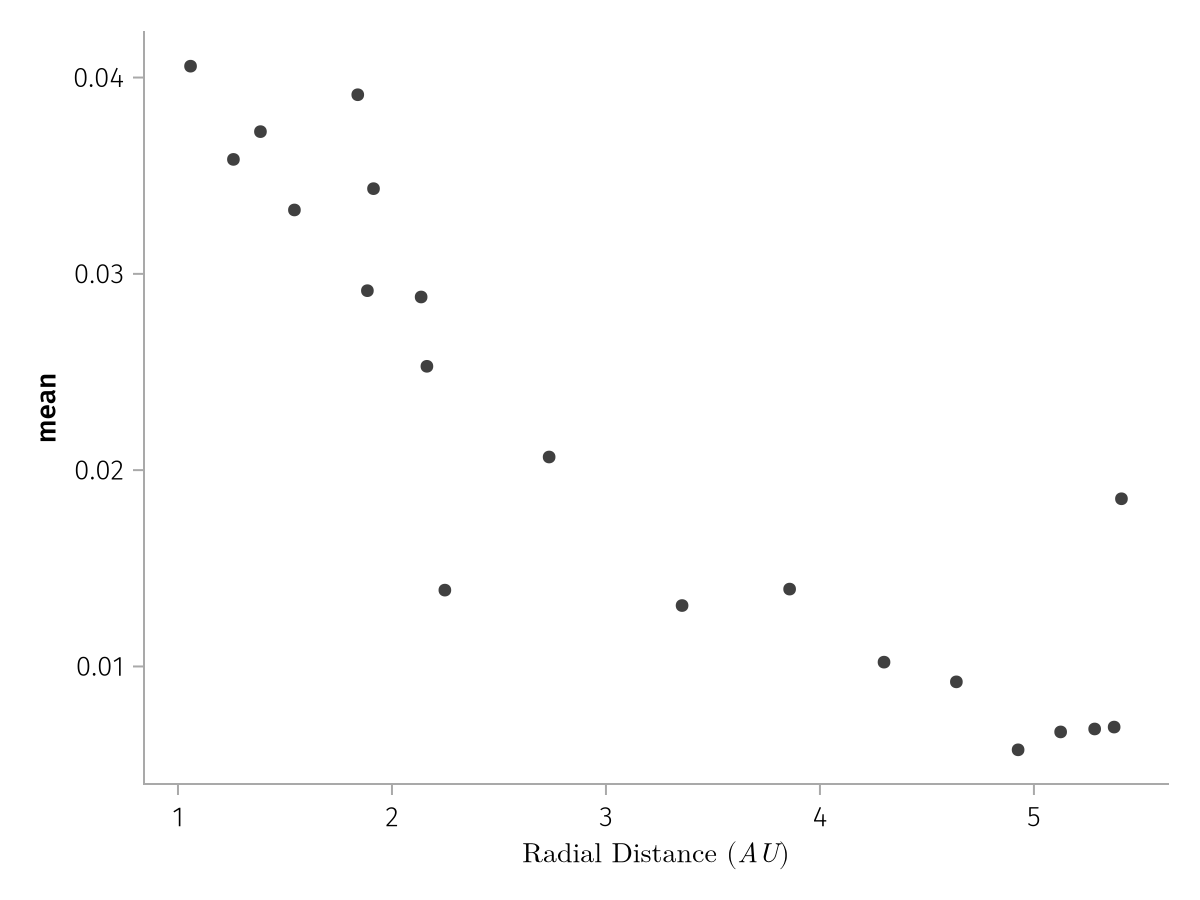

In [103]:
# jno_df.time_bin = year.(jno_df.time);
time_interval = Day(90)
jno_df.time_bin = (jno_df.time - minimum(jno_df.time)) ./ time_interval .|> round
df_grouped = groupby(jno_df, :time_bin);
df = combine(df_grouped, :time => get_wt_fit_params => :mean, :radial_distance => mean)

specs = data(df) * mapping(:radial_distance_mean => r_lab, :mean => x->(1/x))
draw(specs)

In [110]:
function plot_wt_pdf_lim(df; xlims = (1, 1000), ylims = (1e-5, 8e-2), kwargs...)
    f = plot_wt_pdf(df; kwargs...)
    xlims!(xlims...)
    ylims!(ylims...)
    return f
end

using Printf
Base.show(io::IO, f::Float64) = @printf(io, "%.2f", f)

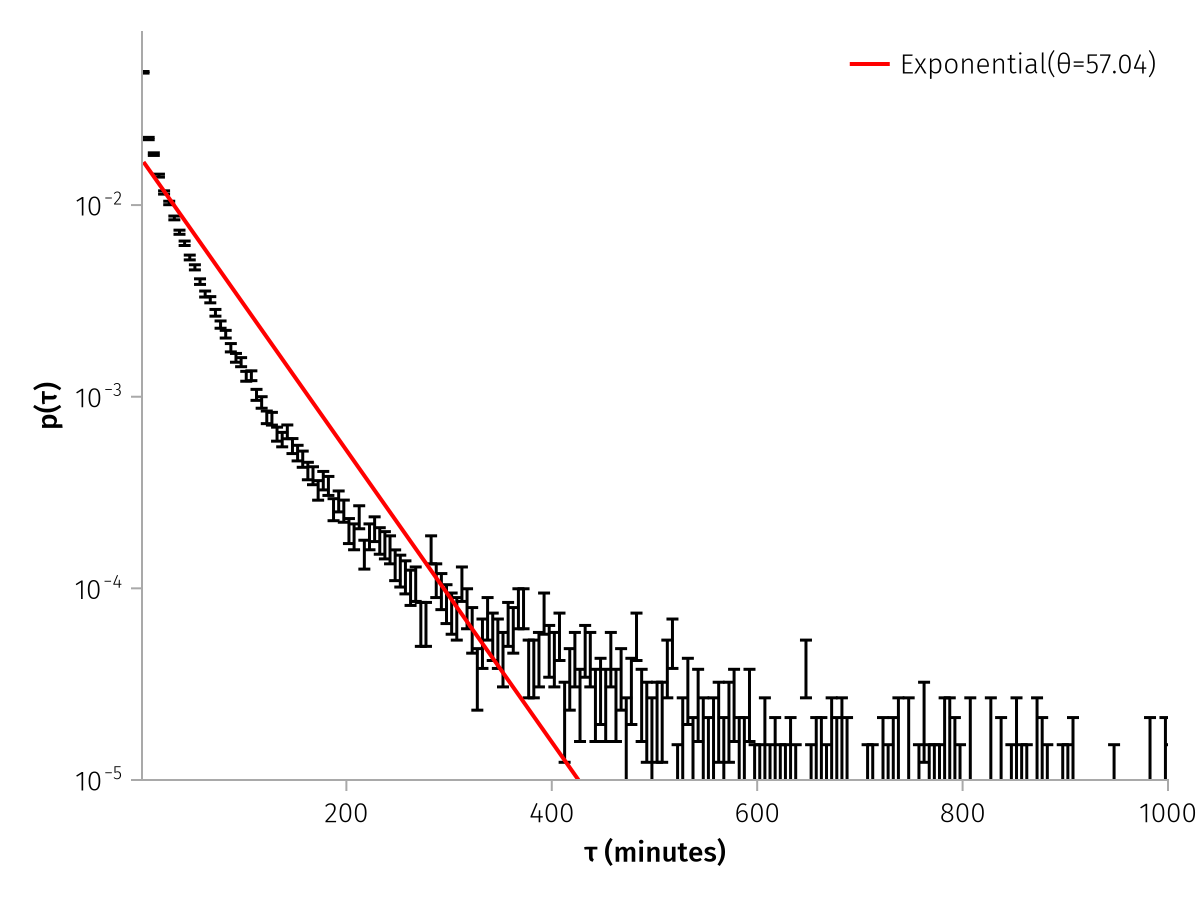

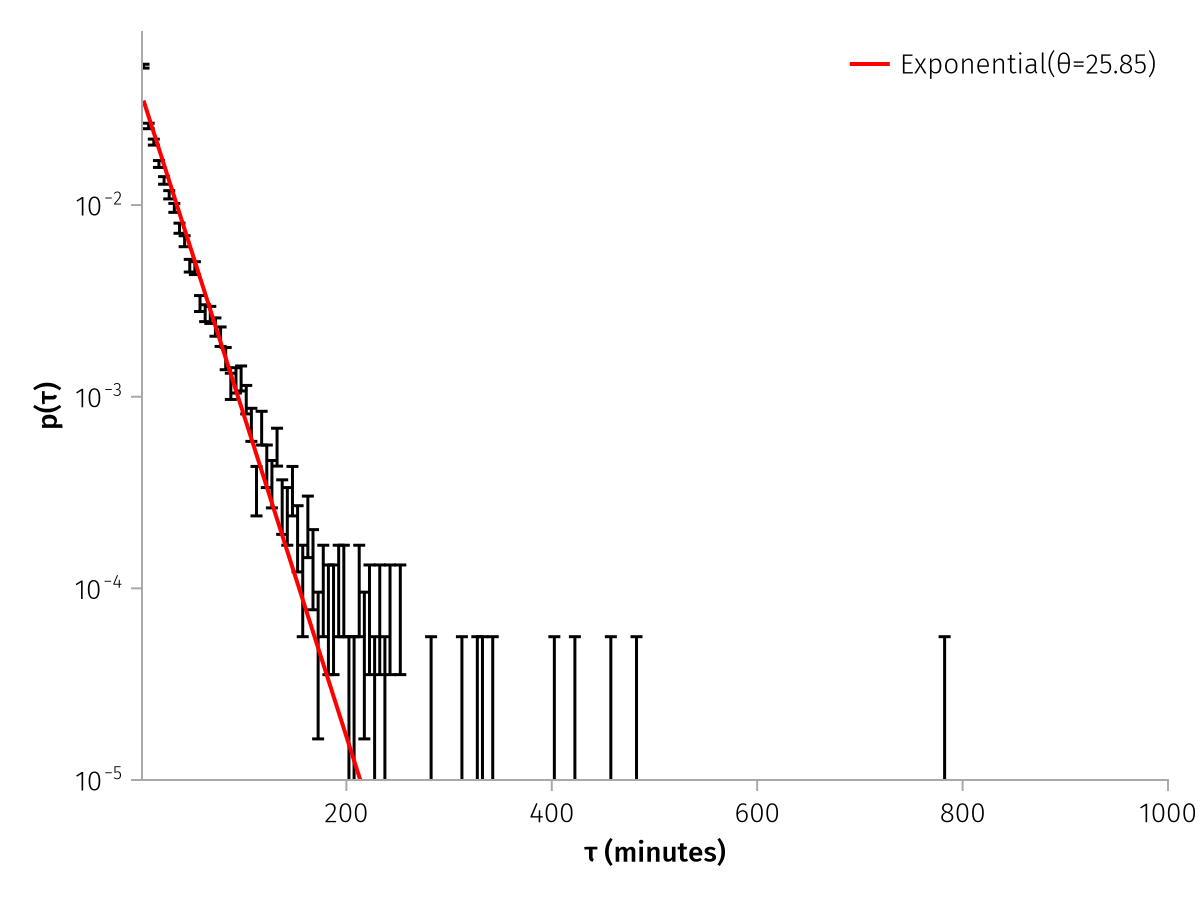

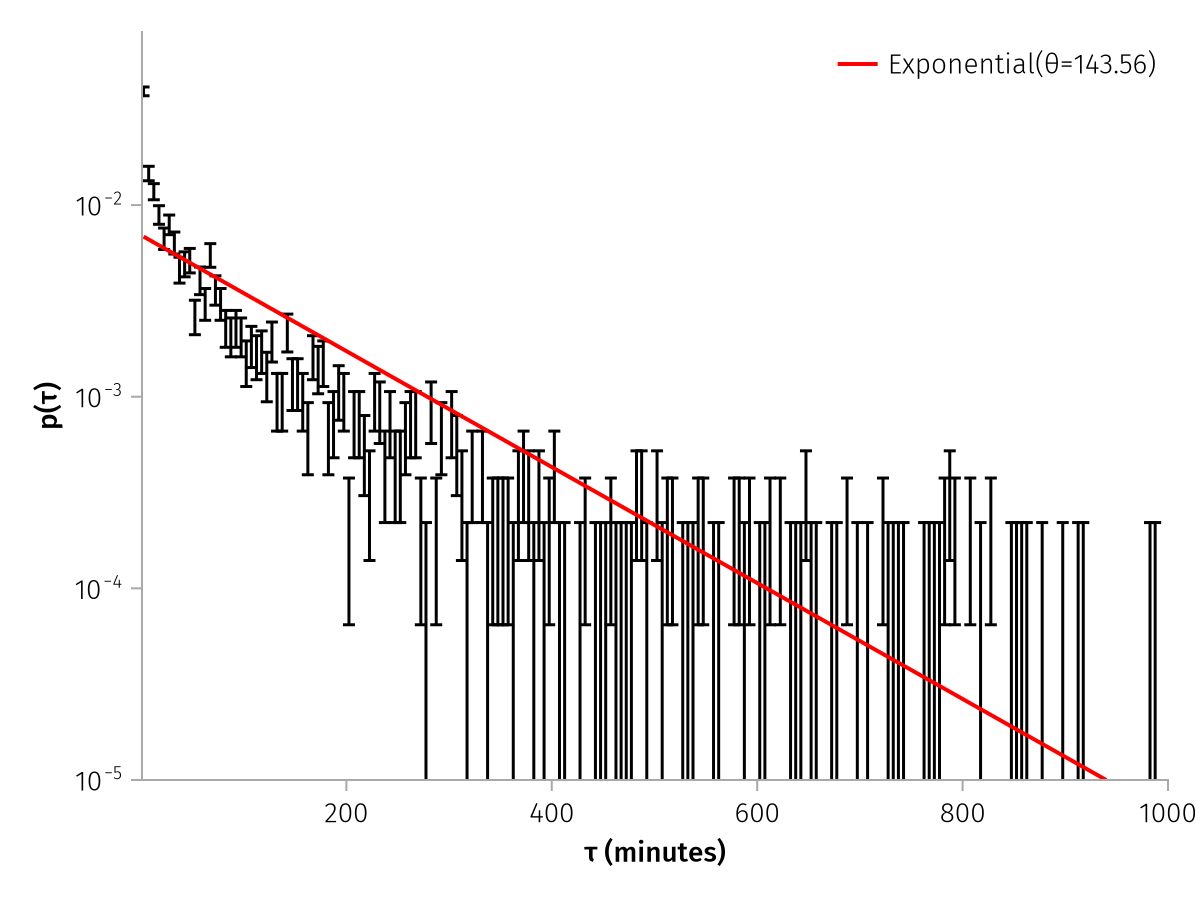

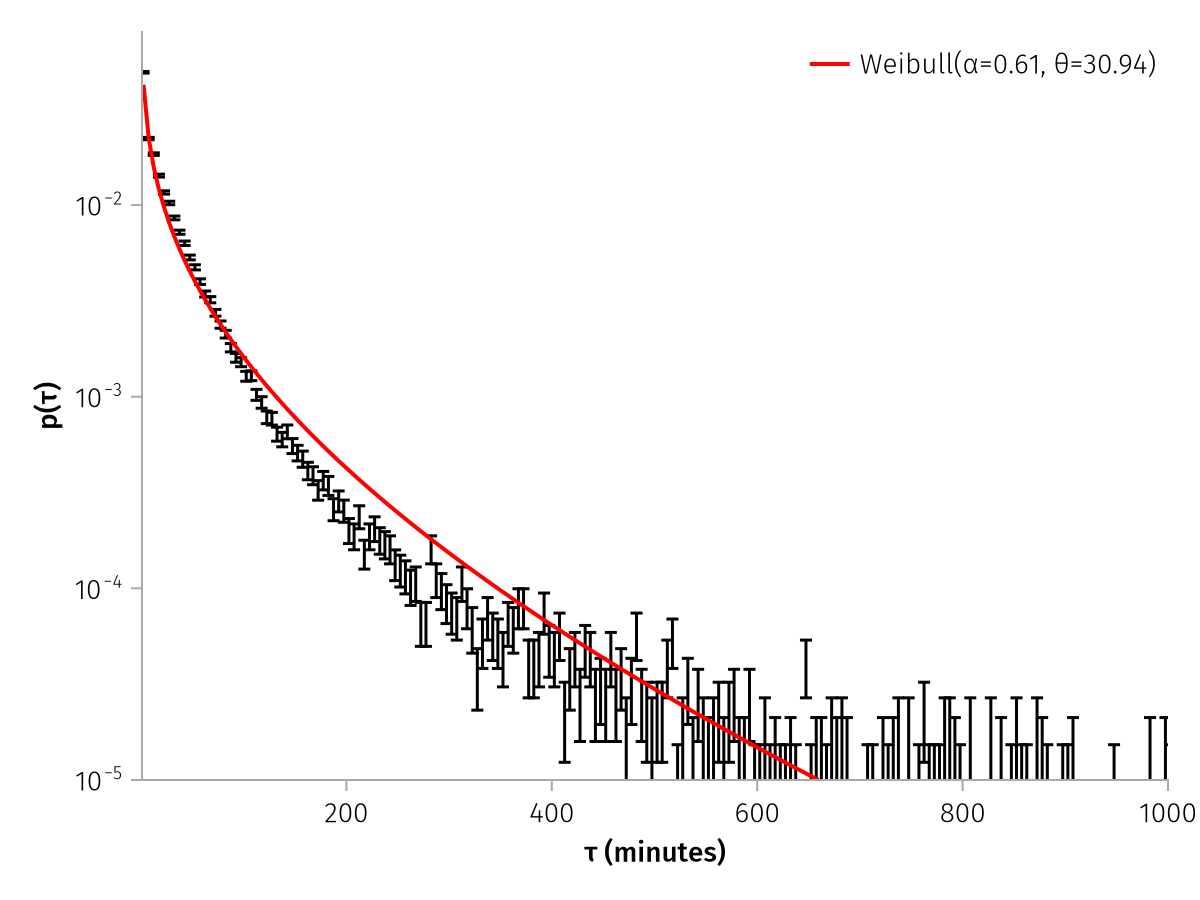

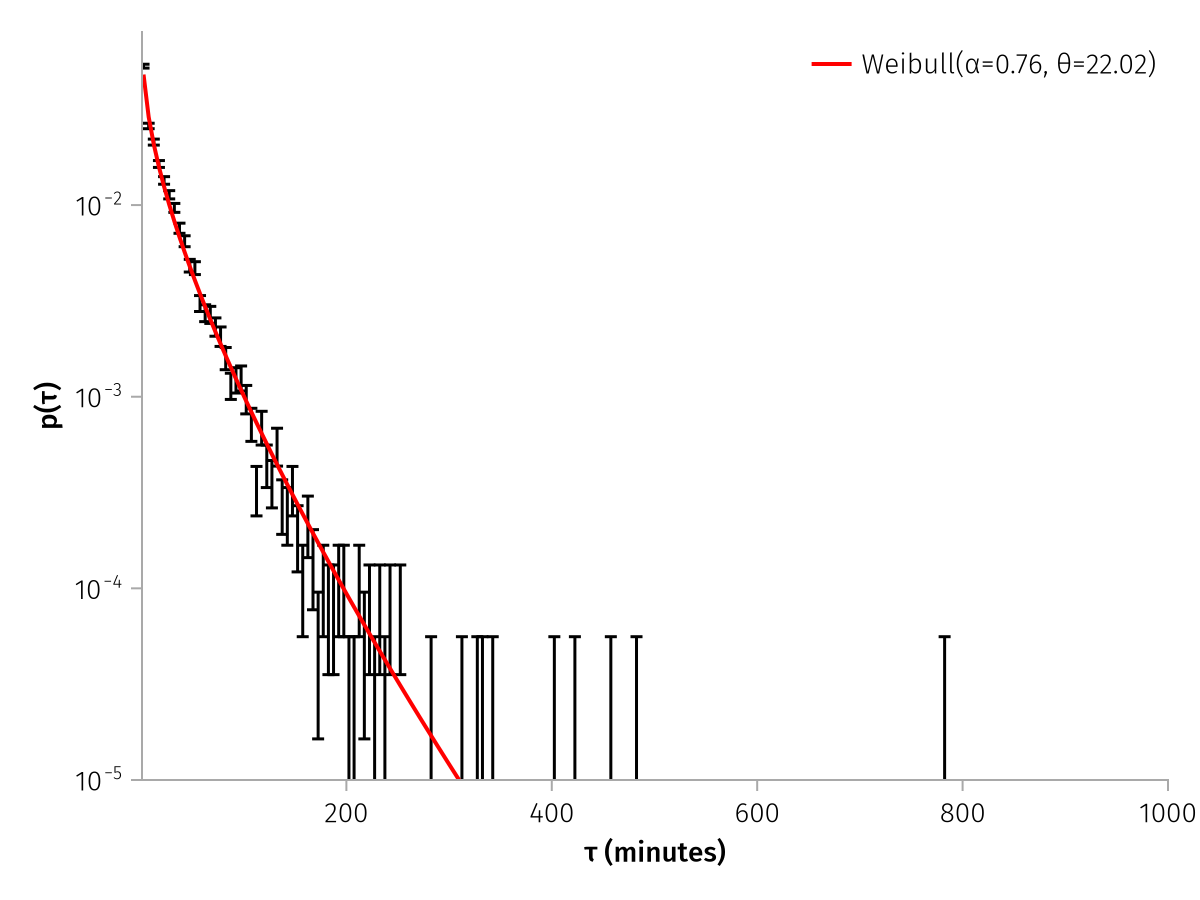

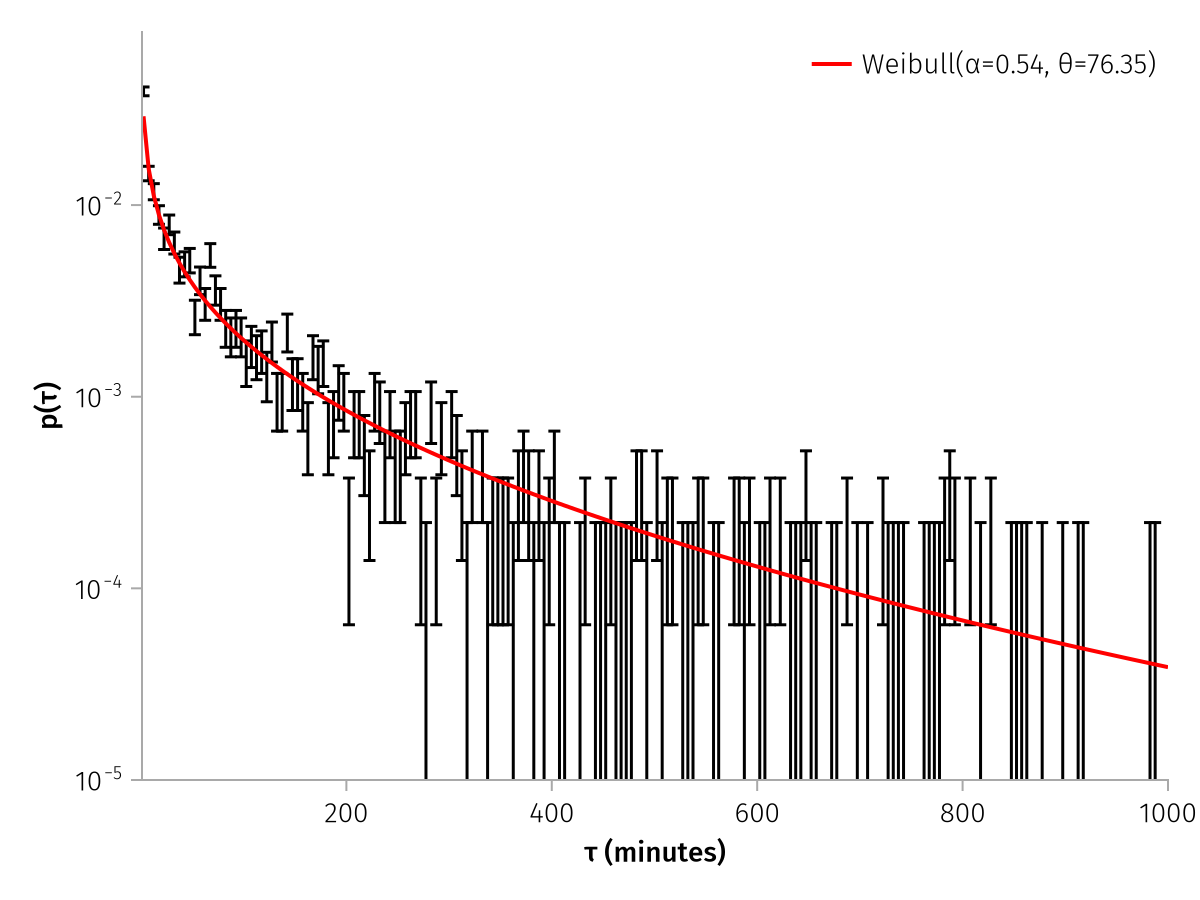

In [121]:
#| column: page
#| layout-ncol: 3
dfs = [ jno_df, jno_df_s1, jno_df_s2 ]
fgs_e = plot_wt_pdf_lim.(dfs, dist=Exponential)
fgs_w = plot_wt_pdf_lim.(dfs, dist=Weibull)
display.(fgs_e);
display.(fgs_w);

## Compare the exponential and Weibull fits for the waiting time distributions of Wind dataset

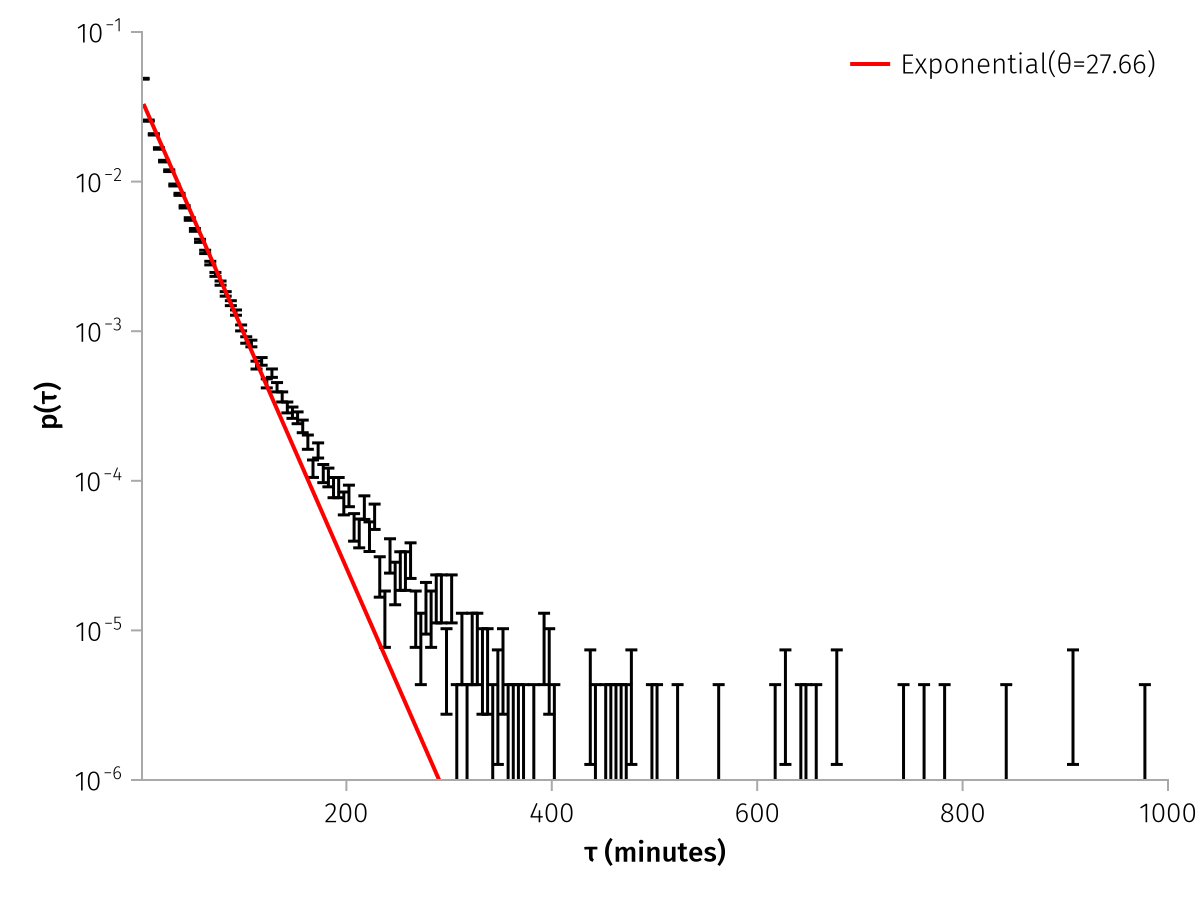

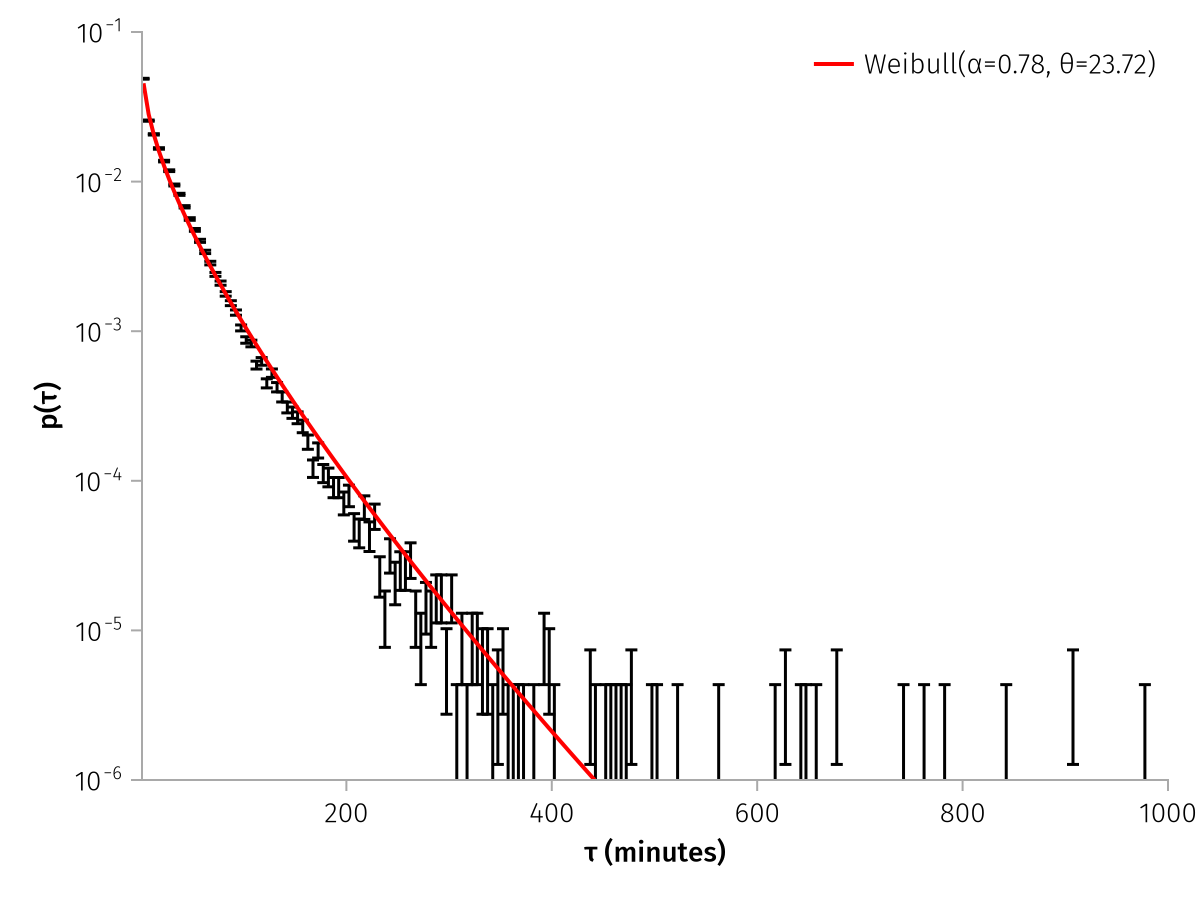

In [112]:
f1 = plot_wt_pdf_lim(wind_df, ylims=(1e-6, 1e-1),)
f2 = plot_wt_pdf_lim(wind_df, dist=Weibull, ylims=(1e-6, 1e-1))
display.([f1, f2]);

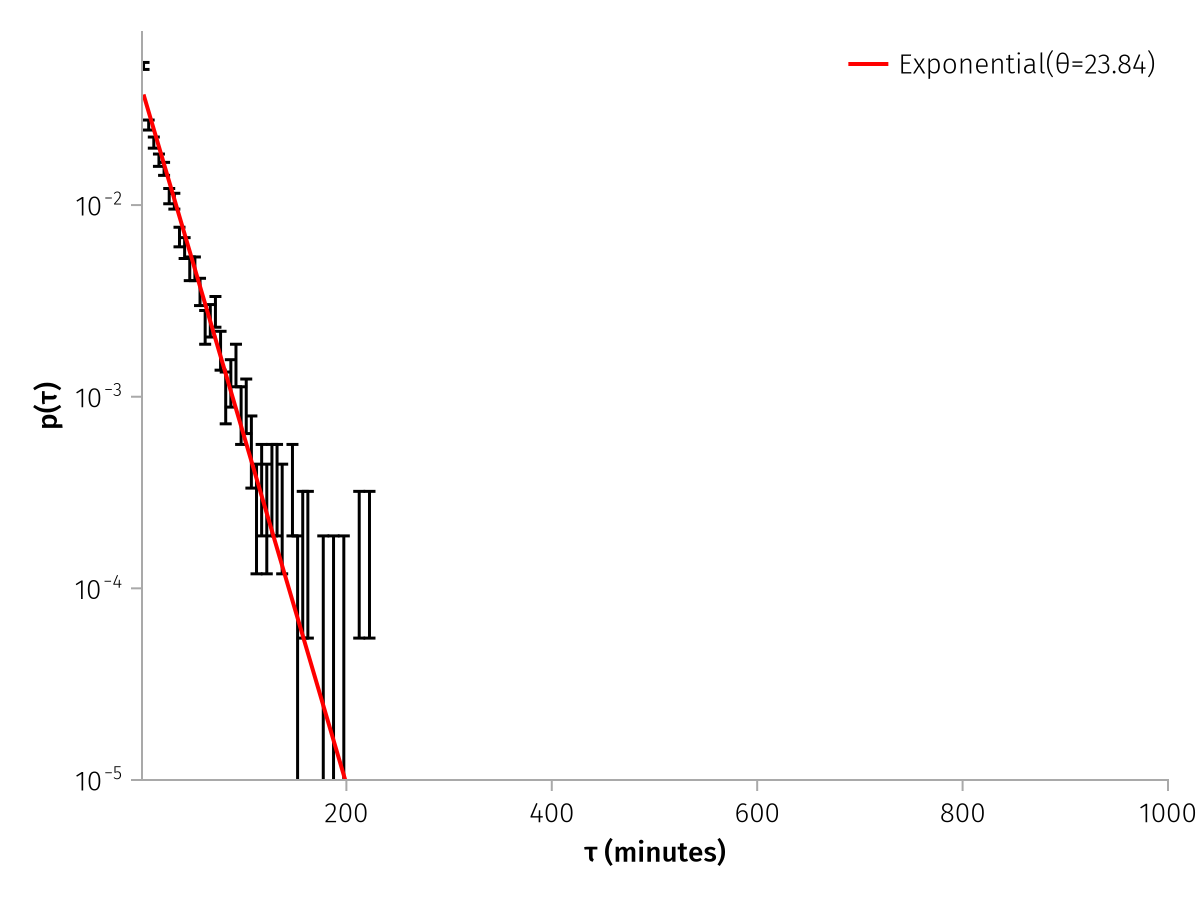

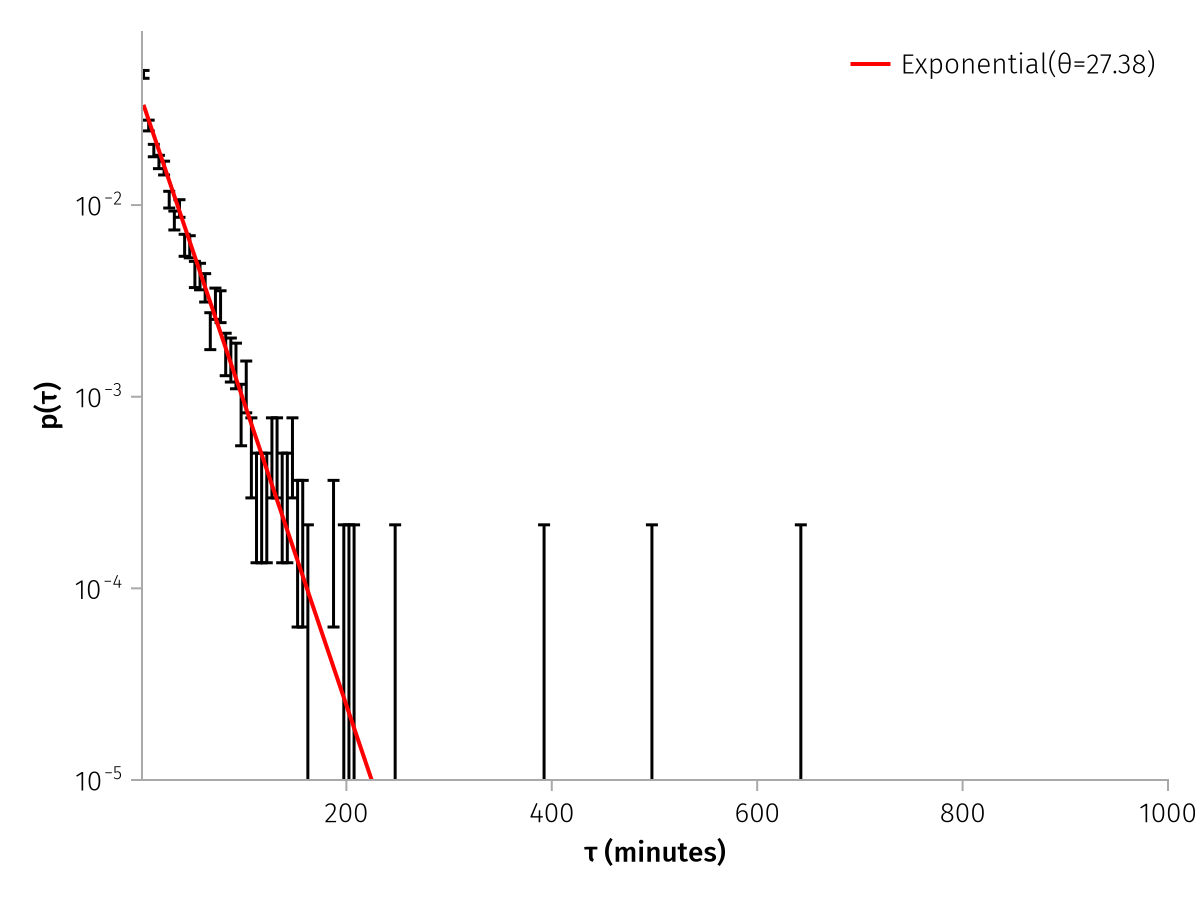

In [115]:
df1 = subset_time(jno_df, Date(2011, 9, 30))
df2 = subset_time(wind_df, Date(2011, 9, 30))
dfs = [ df1, df2 ]
fgs = dfs .|> plot_wt_pdf_lim 
display.(fgs);